In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# eztao imports
import eztao
from eztao.carma import DHO_term, CARMA_term, DRW_term
from eztao.ts import gpSimFull, gpSimByTime, addNoise
from eztao.ts.carma_fit import sample_carma

from tape.ensemble import Ensemble
from tape.utils import ColumnMapper
from tape.analysis import calc_sf2

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39628 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39628/status,
Dashboard: http://127.0.0.1:39628/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45186,Workers: 8
Dashboard: http://127.0.0.1:39628/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:33234,Total threads: 8
Dashboard: http://127.0.0.1:45727/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:42746,


# Tape Single Pixel

In [3]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1556: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1577: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1116: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1116: UserWarning: Divisions for source are not set, certain downstream dask operations may fail a

## 0. Estimate noise for ztf 

In [4]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens._source.compute()

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1


/tmp/ipykernel_83215/4052900771.py:8: RankWarning: Polyfit may be poorly conditioned
  g_polyfit_l18 = np.poly1d(np.polyfit(y[y<18.5] , y_err[y<18.5], deg=3))
/tmp/ipykernel_83215/4052900771.py:9: RankWarning: Polyfit may be poorly conditioned
  g_polyfit_g18 = np.poly1d(np.polyfit(y[y>18.5] , y_err[y>18.5], deg=3))


          3           2
0.000139 x - 0.00202 x - 0.04211 x + 0.6348
           3             2
4.827e-05 x + 0.0003963 x - 0.004047 x - 0.3294


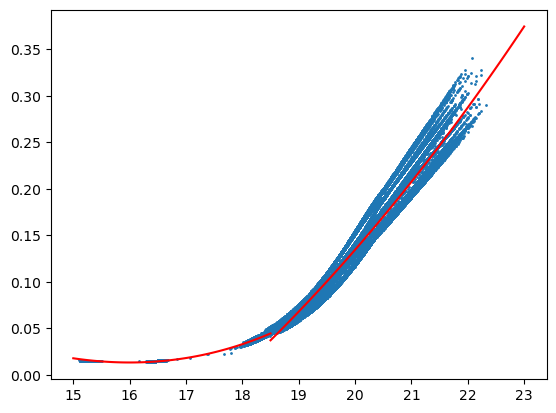

In [6]:
np.sort(ens._source['mag_ztf_source'].compute().values)

sort_array = np.argsort(ens._source['mag_ztf_source'].compute().values)
y = ens._source['mag_ztf_source'].compute().values[sort_array]
y_err = ens._source['magerr_ztf_source'].compute().values[sort_array]


g_polyfit_l18 = np.poly1d(np.polyfit(y[y<18.5] , y_err[y<18.5], deg=3))
g_polyfit_g18 = np.poly1d(np.polyfit(y[y>18.5] , y_err[y>18.5], deg=3))

x_l18 = np.linspace(15, 18.5, 100)
x_g18 = np.linspace(18.5, 23, 100)

plt.scatter(ens._source['mag_ztf_source'], ens._source['magerr_ztf_source'], s=1)
plt.plot(x_l18, g_polyfit_l18(x_l18), c='r')
plt.plot(x_g18, g_polyfit_g18(x_g18), c='r')

print(g_polyfit_l18)
print(g_polyfit_g18)

In [7]:
def err_func_f(mag):
    g_polyfit_l18 = np.poly1d([ 1.38997304e-04, -2.02030371e-03, -4.21095110e-02,  6.34775050e-01])
    g_polyfit_g18 = np.poly1d([ 4.82657946e-05,  3.96290863e-04, -4.04700576e-03, -3.29367881e-01])
    if mag <= 18.5:
        return g_polyfit_l18(mag)
    else:
        return g_polyfit_g18(mag)
    
v_err_func_f = np.vectorize(err_func_f)

In [8]:
name_str = '023922.87-000119.6'

ts_computed = ens._source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

ts = ens._source.compute().loc[name_str]
t_g = ts['mjd_ztf_source'].values
sort_array = np.argsort(t_g)
t_g = t_g[sort_array]
y_g = ts['mag_ztf_source'].values[sort_array]
yerr_g = ts['magerr_ztf_source'].values[sort_array]

In [68]:
# Creating DRW component

# sorted times of observations
t_start = np.min(ts_computed_g['mjd_ztf_source'].values)
tIn = np.sort(ts_computed_g['mjd_ztf_source'].values) - np.min(ts_computed_g['mjd_ztf_source'].values)

# number of light curves to simulate
nLC = 100
# very high SNR as we are going to add noise later manually
SNR = 100

# define a DRW kernel
amp = 10**(-0.935381)
tau = 10**(2.749800)
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

# simulate light curves
t, y, yerr = gpSimByTime(DRW_kernel , SNR, tIn, nLC=nLC, log_flux=True)
y = np.median(ts_computed_g['mag_ztf_source']) + y 

y_drw = np.copy(y)


# Creating periodic component

## random periods and amplitudues
per_amp = np.random.uniform(0, 0.5, nLC)
per_tau = 10**np.random.uniform(1, 4, nLC)
per_phase = np.random.uniform(0, 2*np.pi, nLC)

y_per = np.array([per_amp[i] * np.sin(2*np.pi*(t[i])/per_tau[i] + per_phase[i]) for i in range(nLC)])

# add periodic component
y = y + y_per


# add noise
yerr = v_err_func_f(y)
y = addNoise(y, yerr)

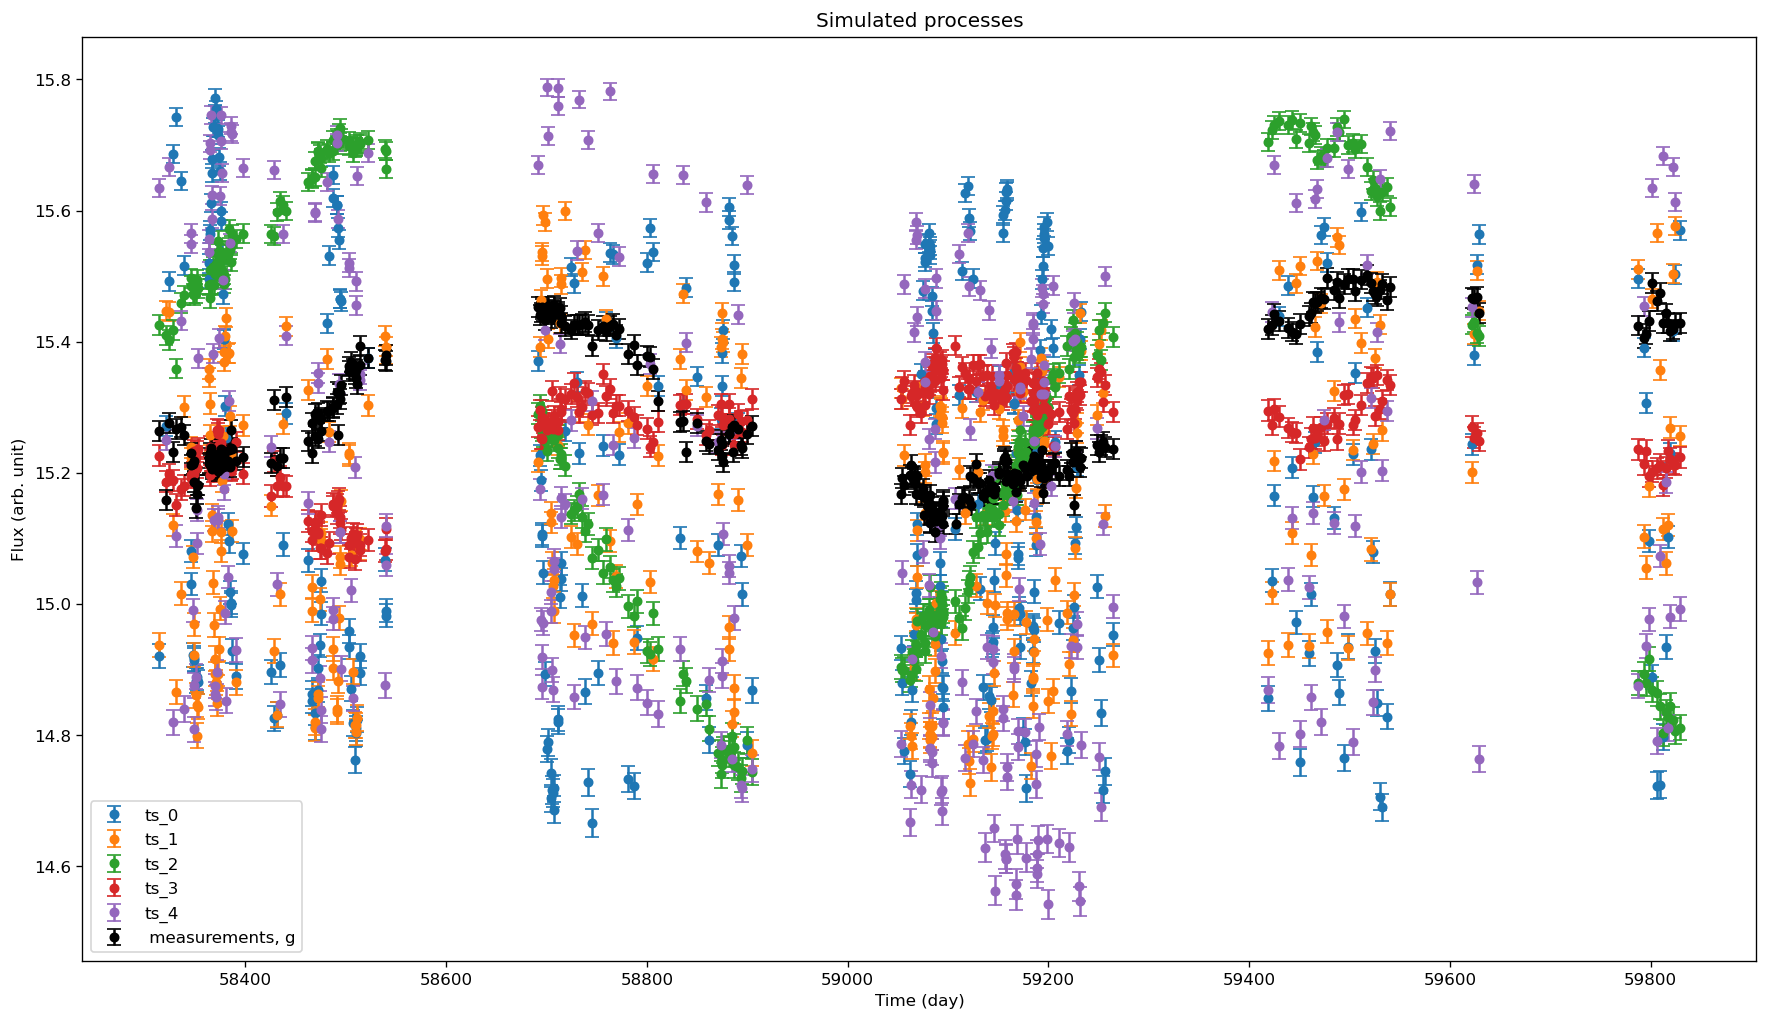

In [69]:
# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=120, figsize=(18,10))

for i in range(nLC)[:5]:
    ax.errorbar(t[i]+t_start, y[i], yerr[i], fmt='.', label=f'ts_{i}', ms=10, capsize=4)
    
ax.errorbar(t_g, y_g, yerr=yerr_g, fmt=".k", capsize=4, label = ' measurements, g', ms=10)

ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated processes')
ax.legend(markerscale=1, loc=3)

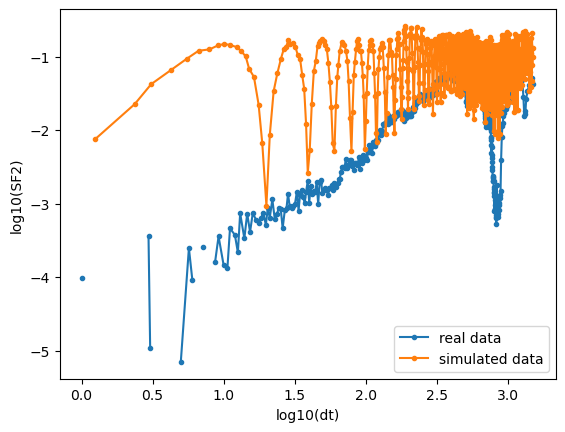

In [70]:
sf_real = calc_sf2(t_g, y_g, yerr_g)
sf_fake = calc_sf2(t[1], y[1], yerr[1])

plt.plot(np.log10(sf_real['dt']), np.log10(sf_real['sf2']), label = 'real data', marker='.')
plt.plot(np.log10(sf_fake['dt']), np.log10(sf_fake['sf2']), label = 'simulated data', marker='.')
plt.xlabel('log10(dt)')
plt.ylabel('log10(SF2)')
plt.legend()

In [26]:
t.shape

(100, 330)

In [71]:
# creating dataframe 
num_lightcurves, num_points = t.shape

# Flatten the 2D arrays
t_flat = t.flatten()
y_flat = y.flatten()
yerr_flat = yerr.flatten()

y_drw_flat = y_drw.flatten()
y_per_flat = y_per.flatten()

# Create a DataFrame
df = pd.DataFrame({
    'lc_nr': np.repeat(np.arange(num_lightcurves), num_points),
    'drw_amp': np.repeat(np.full(num_lightcurves, amp), num_points),
    'drw_tau': np.repeat(np.full(num_lightcurves, tau), num_points),
    'per_amp': np.repeat(np.full(num_lightcurves, per_amp), num_points),
    'per_tau': np.repeat(np.full(num_lightcurves, per_tau), num_points),
    't': t_flat,
    'y': y_flat,
    'yerr': yerr_flat,
    'y_drw': y_drw_flat,
    'y_per': y_per_flat
})

In [72]:
df

,lc_nr,drw_amp,drw_tau,per_amp,per_tau,t,y,yerr,y_drw,y_per
0,0,0.116043,562.082417,0.414069,39.388906,0.000000,14.921010,0.018306,15.321958,-0.390113
1,0,0.116043,562.082417,0.414069,39.388906,7.056726,15.270978,0.015429,15.337543,-0.042701
2,0,0.116043,562.082417,0.414069,39.388906,9.997028,15.491999,0.014395,15.333305,0.148079
3,0,0.116043,562.082417,0.414069,39.388906,14.113451,15.686153,0.013579,15.345659,0.353341
4,0,0.116043,562.082417,0.414069,39.388906,17.053754,15.742979,0.013473,15.327101,0.412764
...,...,...,...,...,...,...,...,...,...,...
32995,99,0.116043,562.082417,0.457704,143.185067,1504.062670,14.828088,0.019181,15.294637,-0.451733
32996,99,0.116043,562.082417,0.457704,143.185067,1506.022871,14.852264,0.019187,15.298747,-0.456394
32997,99,0.116043,562.082417,0.457704,143.185067,1508.963174,14.823013,0.019180,15.300086,-0.457053
32998,99,0.116043,562.082417,0.457704,143.185067,1510.923375,14.814113,0.019141,15.300126,-0.453267
